In [16]:
import simpegDarcy as Darcy
import simpegSP as SP
from SimPEG import Mesh, Maps, Utils
from pymatsolver import PardisoSolver
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/sgkang/anaconda2/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['find']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [311]:
# Generate 3D mesh
csx, csy, csz = 5., 5., 2.5
ncx, ncy, ncz = 30, 30, 20
npad = 8
hx = [(csx, npad, -1.3), (csx, ncx), (csx, npad, 1.3)]
hy = [(csy, npad, -1.3), (csy, ncy), (csy, npad, 1.3),]
hz = [(csz, npad, -1.3), (csz, ncz-4), (csz/2., 4)]
mesh = Mesh.TensorMesh([hx, hy, hz], "CC0")
mesh._x0 = np.r_[mesh.x0[0], mesh.x0[1], -mesh.hz[:5].sum()]
# Generate Darcy problem
Darcyprb = Darcy.Problem_CC(mesh, KMap=Maps.IdentityMap(mesh))
# Set boundary condition
bc = [["dirichlet", "dirichlet"], ["neumann", "neumann"], ["neumann", "neumann"]]
hbc = [[50., 30.] ,[0., 0.], [0., 0.]]
Darcyprb.setBC(bc, hbc)
# Set Darcy survey
locs = Utils.ndgrid(mesh.vectorCCx, mesh.vectorCCy, np.r_[mesh.vectorCCz[-1]])
rx = Darcy.DarcyRx(locs)
Darcysurvey = Darcy.DarcySurvey([rx])
# Make hydraulic conductivity model (m/s)
K = np.ones(mesh.nC)*1e-7
layerind1 = np.logical_and(mesh.gridCC[:,2]>=20., mesh.gridCC[:,2]<30.)
blkind1 = np.logical_and(mesh.gridCC[:,0]>-30., mesh.gridCC[:,0]<30.) & np.logical_or(mesh.gridCC[:,1]<-30., mesh.gridCC[:,1]>30.)
K[layerind1] = 1e-5
K[blkind1 & layerind1] = 1e-9
# Pair the survey to the problem
Darcysurvey.pair(Darcyprb)
Darcyprb.Solver = PardisoSolver
L = np.ones(mesh.nC) * 1e-7
L[layerind1] = 1e-1
L[blkind1 & layerind1] = 1e-9


In [312]:
# Run simulation
h = Darcyprb.fields(K)

In [313]:
gradh = Darcyprb.gradh(h)
vel = Darcyprb.vel(h)

In [314]:
# out = mesh.plotSlice(h, grid=True, ind= 15, normal="Z")
# plt.colorbar(out[0])
# out = mesh.plotSlice(gradh, grid=False, normal="Z", view="vec", vType="F", ind=15)
# plt.colorbar(out[0])
# out = mesh.plotSlice(gradh, grid=False, normal="Y", view="vec", vType="F", clim=out[0].get_clim(), ind =8)
# plt.colorbar(out[0])

In [315]:
from SimPEG import Survey

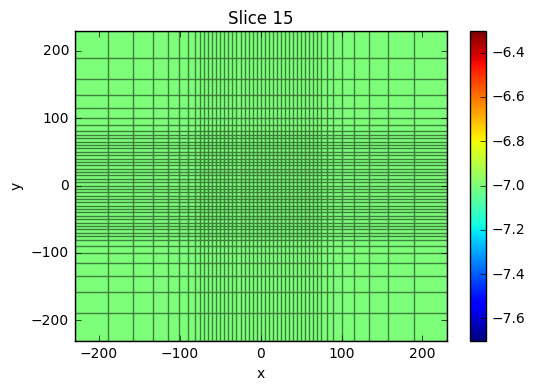

In [316]:
out = mesh.plotSlice(np.log10(L), grid=True, ind= 15, normal="Z")
plt.colorbar(out[0])

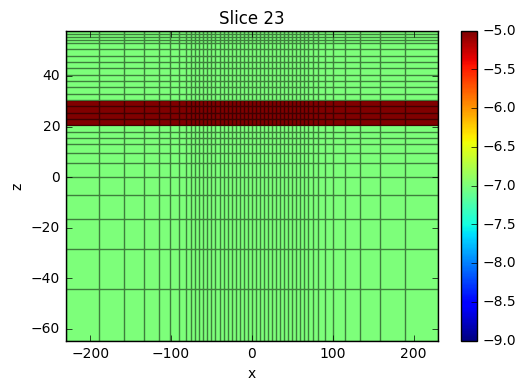

In [317]:
out = mesh.plotSlice(np.log10(K), grid=True, normal="Y", clim=(-9, -5))
plt.colorbar(out[0])

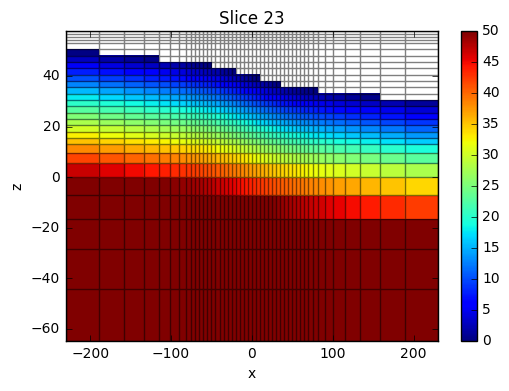

In [318]:
p = Darcyprb.p(h)
p[p<0.] = np.nan
out = mesh.plotSlice(p, grid=True, normal="Y", clim=(0, 50))
plt.colorbar(out[0])

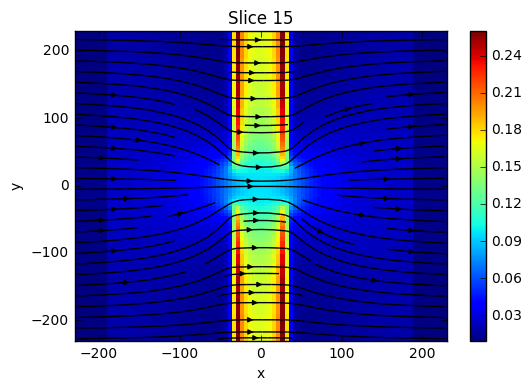

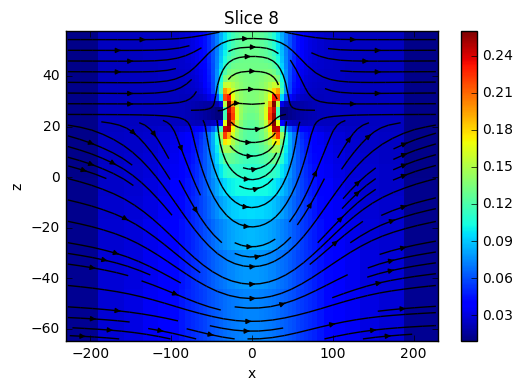

In [319]:
out = mesh.plotSlice(gradh, grid=False, normal="Z", view="vec", vType="F", ind=15)
plt.colorbar(out[0])
out = mesh.plotSlice(gradh, grid=False, normal="Y", view="vec", vType="F", clim=out[0].get_clim(), ind =8)
plt.colorbar(out[0])

In [320]:
fxm, fxp, fym, fyp, fzm, fzp = mesh.faceBoundaryInd
find = np.r_[fxm+fxp, fym+fyp, fzm+fzp]
vel[find] = 0.

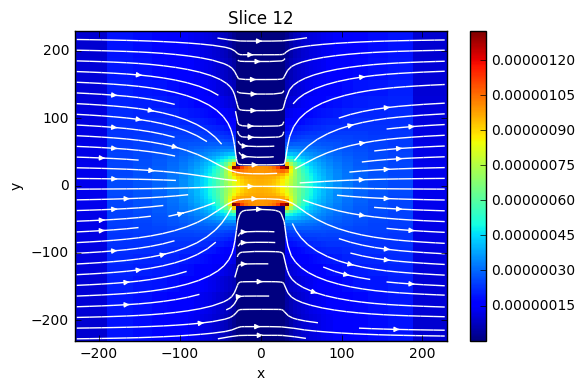

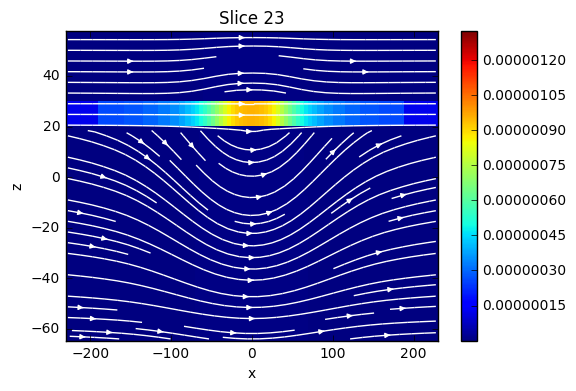

In [321]:
out = mesh.plotSlice(vel, normal="Z", view="vec", vType="F", streamOpts={"color":"w"}, ind=12)
plt.colorbar(out[0])
mesh.plotSlice(vel, normal="Y", view="vec", vType="F", clim=out[0].get_clim(), streamOpts={"color":"w"})
plt.colorbar(out[0])

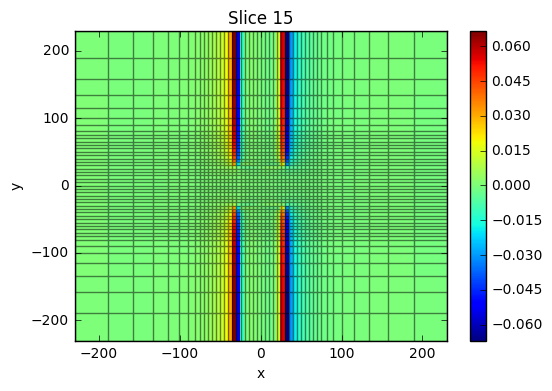

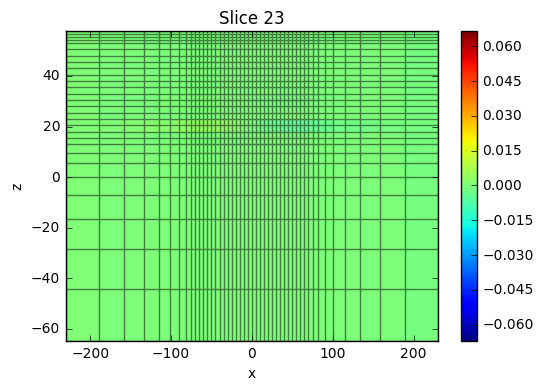

In [322]:
out = mesh.plotSlice(Darcyprb.divgradh(h), grid=True, normal="Z", ind=15)
plt.colorbar(out[0])
mesh.plotSlice(Darcyprb.divgradh(h), grid=True, normal="Y", clim=out[0].get_clim())
plt.colorbar(out[0])

In [323]:
L0 = 1e-5
# jsCC = np.r_[Qv, Qv, Qv]*(mesh.aveF2CCV*vel) 

In [324]:
# Make SP survey
dx = 5.
x = mesh.vectorCCx[np.logical_and(mesh.vectorCCx<80., mesh.vectorCCx>-80.)]
y = mesh.vectorCCy[np.logical_and(mesh.vectorCCy<80., mesh.vectorCCy>-80.)]
xyzM = Utils.ndgrid(x*0., y*0., np.r_[mesh.vectorCCz[-1]])
xyzN = Utils.ndgrid(x, y, np.r_[mesh.vectorCCz[-1]])

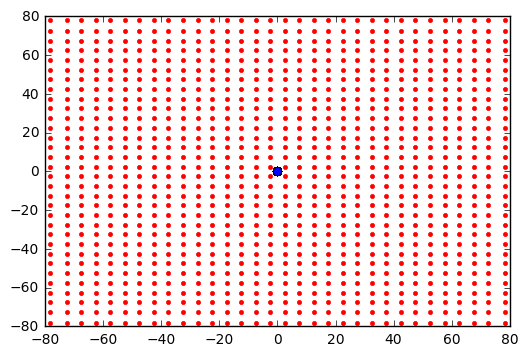

In [325]:
plt.plot(xyzM[:,0], xyzM[:,1], 'bo')
plt.plot(xyzN[:,0], xyzN[:,1], 'r.')

In [384]:
#SP problem with Head map
sigma = np.ones(mesh.nC)*1e-3
sigma[layerind1] = 1e-3
sigma[blkind1 & layerind1] = 1e-1

prb = SP.Problem_CC(mesh, sigma=sigma, hMap=Maps.IdentityMap(mesh), Solver=PardisoSolver)
rx = SP.Rx.Dipole(xyzN, xyzM)
src = SP.Src.StreamingCurrents([rx], L=np.ones(mesh.nC), mesh=mesh, modelType="Head")
survey = SP.Survey([src])
survey.pair(prb)
dobs = survey.dpred(h)
# q = src.eval(prb)

In [385]:
js = src.MfLiI*prb.Grad*prb.h

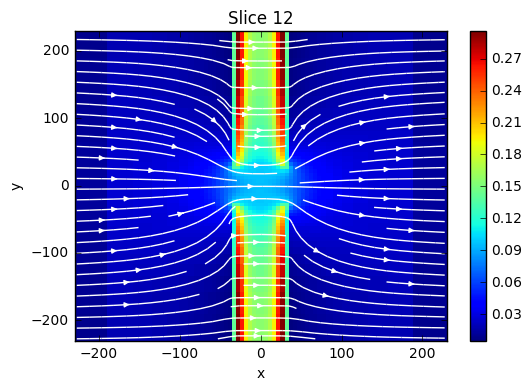

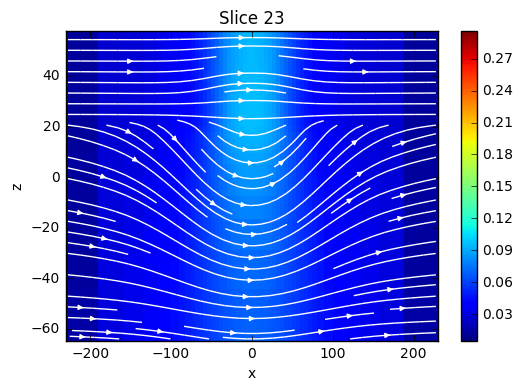

In [386]:
out = mesh.plotSlice(js, normal="Z", view="vec", vType="F", streamOpts={"color":"w"}, ind=12)
plt.colorbar(out[0])
mesh.plotSlice(js, normal="Y", view="vec", vType="F", clim=out[0].get_clim(), streamOpts={"color":"w"})
plt.colorbar(out[0])

In [337]:
# print mesh

In [362]:
wires = Maps.Wires(('jsx', mesh.nC), ('jsy', mesh.nC), ('jsz', mesh.nC))
prb = SP.Problem_CC(mesh, sigma=sigma, jsxMap=wires.jsx, jsyMap=wires.jsy, jszMap=wires.jsz, Solver=PardisoSolver)
rx = SP.Rx.Dipole(xyzN, xyzM)
src = SP.Src.StreamingCurrents([rx], L=np.ones(mesh.nC), mesh=mesh, modelType="CurrentDensity")
survey = SP.Survey([src])
survey.pair(prb)

In [363]:
# out = mesh.plotSlice(q, grid=True, normal="Z", ind=15)
# plt.colorbar(out[0])
# mesh.plotSlice(q, grid=True, normal="Y", clim=out[0].get_clim(), ind=5)
# plt.colorbar(out[0])

In [364]:
# # Generate Full sensitivity
# I = np.diag(np.ones_like(dobs))
# J = np.zeros((dobs.size, mesh.nC))
# for i in range(dobs.size):
#     J[i,:] = prb.Jtvec(sigma, I[:,i])
#     JtJ = (J**2).sum(axis=0)
# JtJ /= JtJ.max()
# prb.G = J

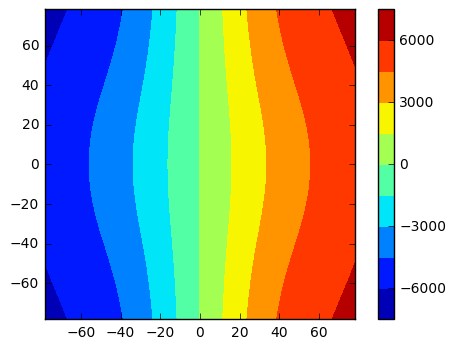

In [365]:
out = Utils.plot2Ddata(xyzN, dobs*1e3)
plt.colorbar(out[0])

In [366]:
depthweight = 1./ ((abs(mesh.gridCC[:,2]-mesh.vectorCCz[-1])+0.5)**1.)
depthweight /= depthweight.max()

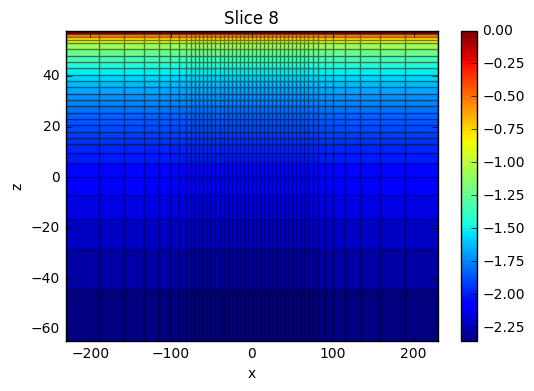

In [367]:
out = mesh.plotSlice(np.log10(depthweight), grid=True, normal="Y", ind=8)
plt.colorbar(out[0])

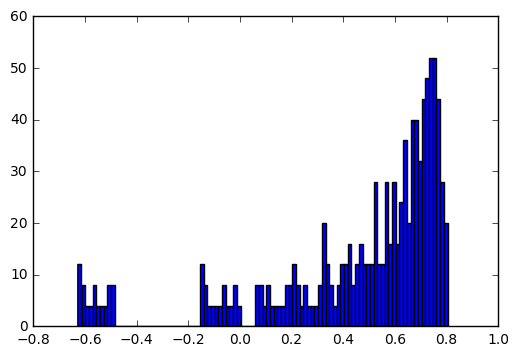

In [368]:
out = hist(np.log10(abs(dobs)), bins=100)

In [369]:
from SimPEG.EM.Static.SIP.Regularization import MultiRegularization

In [370]:
from SimPEG import (Mesh, Maps, Utils, DataMisfit, Regularization,
                    Optimization, Inversion, InvProblem, Directives)
survey.std = 0.
survey.eps = abs(dobs).max() * 0.05
survey.dobs = dobs
 
dmisfit = DataMisfit.l2_DataMisfit(survey)
regmap = Maps.IdentityMap(nP = mesh.nC*3)
reg = MultiRegularization(mesh, mapping=regmap ,nModels=3)
reg.cell_weights = depthweight
reg.alpha_s = 1.
reg.alpha_x = 0.
reg.alpha_y = 0.
reg.alpha_z = 0.
opt = Optimization.InexactGaussNewton(maxIter=100, tolX=1e-20, tolF=1e-20)
opt.maxIterLS = 20
IRLS = Directives.Update_IRLS(norms=([0.,1.,1.,1.]),
                                     eps=None, f_min_change=1e-3,
                                     minGNiter=3)
# senseweight = Directives.Update_Wj()
invProb = InvProblem.BaseInvProblem(dmisfit, reg, opt)
target = Directives.TargetMisfit()
# Create an inversion object
beta = Directives.BetaSchedule(coolingFactor=5, coolingRate=3)
betaest = Directives.BetaEstimate_ByEig()
betaest.beta0_ratio = 1e-10
# updateprecond = Directives.Update_lin_PreCond()
# inv = Inversion.BaseInversion(invProb, directiveList=[betaest, updateprecond, IRLS])
inv = Inversion.BaseInversion(invProb, directiveList=[beta, betaest, target])
prb.counter = opt.counter = Utils.Counter()
opt.LSshorten = 0.5
opt.remember('xc')
m0 = np.ones(mesh.nC*3)*0.
reg.mref = m0
mopt = inv.run(m0)

SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                    ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.67e+00  8.19e+04  0.00e+00  8.19e+04    4.89e+10      0              
   1  1.67e+00  7.93e+04  2.96e-13  7.93e+04    3.61e+09      0              
   2  1.67e+00  7.93e+04  2.53e-13  7.93e+04    1.63e+08      0              
------------------------- STOP! -------------------------
1 : |fc-fOld| = 0.0000e+00 <= tolF*(1+|f0|) = 8.1939e-16
0 : |xc-x_last| = 5.3720e+00 <= tolX*(1+|x0|) = 1.0000e-20
0 : |proj(x-g)-x|    = 1.6323e+08 <= tolG          = 1.0000e-01
0 : |proj(x-g)-x|    = 1.6323e+08 <= 1e3*eps       = 1.0000e-02
0 : maxIter   =     100    <= iter       

In [371]:
xc = opt.recall("xc")

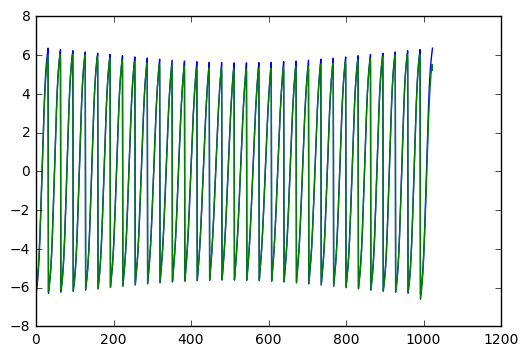

In [372]:
plt.plot(dobs)
plt.plot(invProb.dpred)

In [373]:
# fig = plt.figure(figsize = (12, 4))
# ax = plt.subplot(111)
# ax_1 = ax.twinx()
# out = ax.hist(abs(reg.l2model), bins=100)
# ax.set_xscale("linear")
# ax.set_yscale("log")
# temp = np.sort(abs(reg.l2model))
# ax_1.plot(temp, temp / (temp**2 + (reg.eps_p)**2))
# plt.xlim(0, 0.0006)

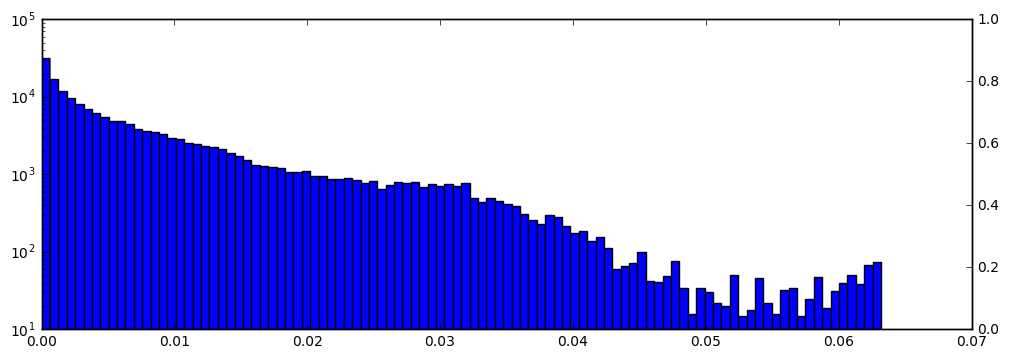

In [374]:
fig = plt.figure(figsize = (12, 4))
ax = plt.subplot(111)
ax_1 = ax.twinx()
out = ax.hist(abs(mopt), bins=100)
ax.set_xscale("linear")
ax.set_yscale("log")
temp = np.sort(abs(mopt))
# ax_1.plot(temp, temp / (temp**2 + (reg.eps_p)**2))
# plt.xlim(0, 0.0006)

In [375]:
0.00001

1e-05

In [376]:
# out = mesh.plotSlice(reg.l2model, grid=True, normal="Z", ind=15, clim=(-0.0001, 0.0001))
# plt.colorbar(out[0])
# mesh.plotSlice(reg.l2model, grid=True, normal="Y", clim=out[0].get_clim(), ind=5)
# plt.colorbar(out[0])

In [377]:
print mopt.min()
print mopt.max()

-0.0631788169548
0.0631576530841


In [378]:
mesh.vectorCCz

array([-54.37336076, -36.33316213, -22.45608625, -11.7814125 ,
        -3.570125  ,   2.74625   ,   7.605     ,  11.3425    ,
        14.2175    ,  16.7175    ,  19.2175    ,  21.7175    ,
        24.2175    ,  26.7175    ,  29.2175    ,  31.7175    ,
        34.2175    ,  36.7175    ,  39.2175    ,  41.7175    ,
        44.2175    ,  46.7175    ,  49.2175    ,  51.7175    ,
        53.5925    ,  54.8425    ,  56.0925    ,  57.3425    ])

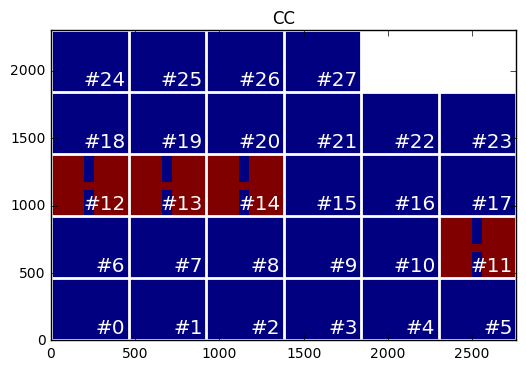

In [379]:
out = mesh.plotImage(L)

(0, 55)

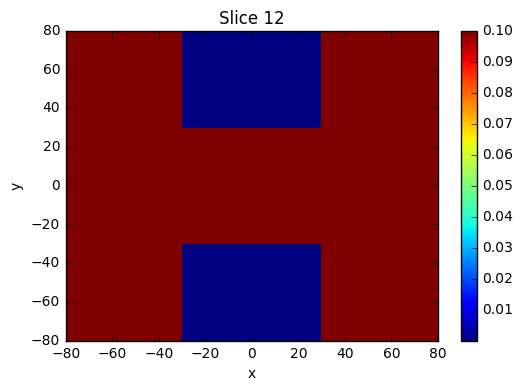

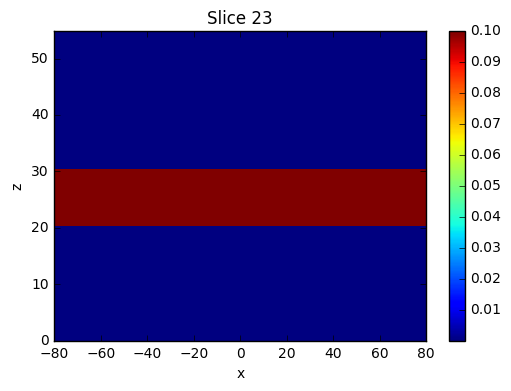

In [380]:
out = mesh.plotSlice(L, ind=12)
plt.colorbar(out[0])
plt.xlim(-80, 80)
plt.ylim(-80, 80)
mesh.plotSlice(L, normal="Y")
plt.colorbar(out[0])
plt.xlim(-80, 80)
plt.ylim(0, 55)

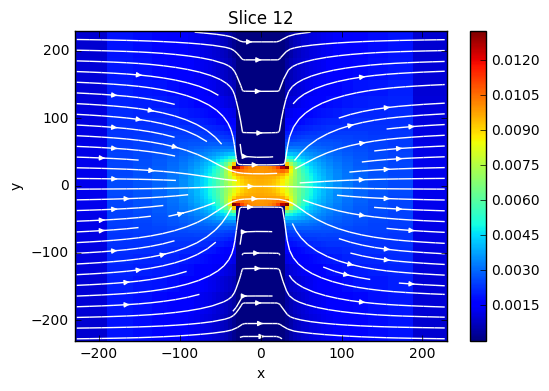

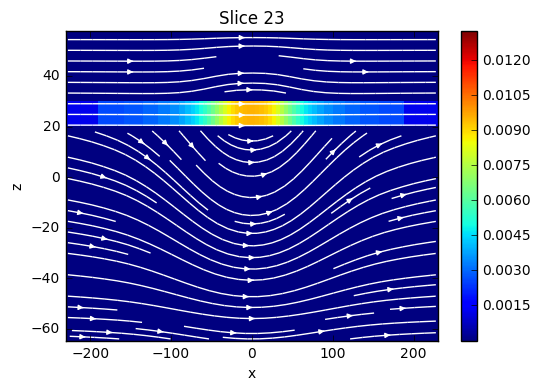

In [381]:
out = mesh.plotSlice(js, normal="Z", view="vec", vType="F", streamOpts={"color":"w"}, ind=12)
plt.colorbar(out[0])
mesh.plotSlice(js, normal="Y", view="vec", vType="F", clim=out[0].get_clim(), streamOpts={"color":"w"})
plt.colorbar(out[0])

(0, 55)

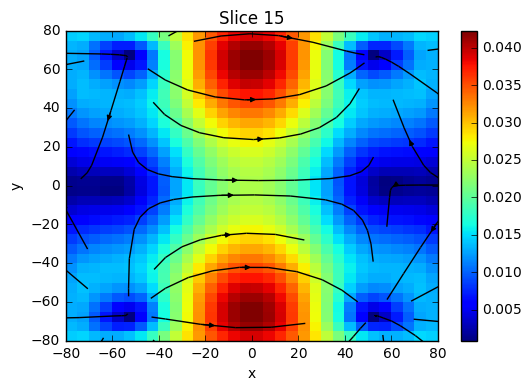

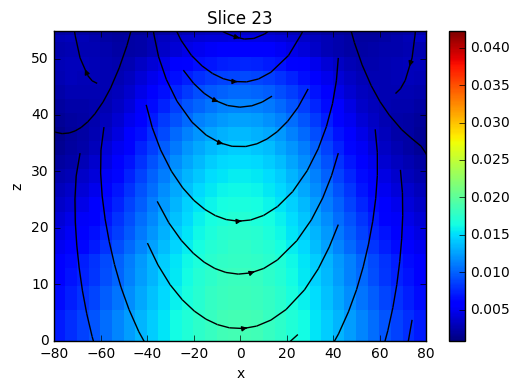

In [382]:
out = mesh.plotSlice(mopt, view='vec', vType="CCv", ind=15)
plt.colorbar(out[0])
plt.xlim(-80, 80)
plt.ylim(-80, 80)
mesh.plotSlice(mopt, view='vec', vType="CCv", normal="Y")
plt.colorbar(out[0])
plt.xlim(-80, 80)
plt.ylim(0, 55)

In [359]:
# plt.plot(survey.dobs)
# plt.plot(invProb.dpred)

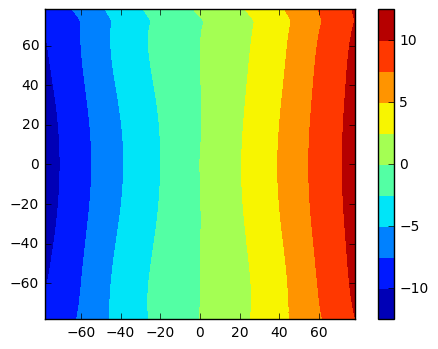

In [360]:
out = Utils.plot2Ddata(xyzN, invProb.dpred*1e3)
plt.colorbar(out[0])